Brief Summary of Project

Data for analysis

Data sources:
API: State median household income
CSV :  Alcohol Consumption per capita(with four alcohol categories and two age ranges)
Web Scraping: State average temperature

In [4]:
#set the wd
import os

# Specify the directory you want to change to
new_directory = 'C:/Users/augus/The default Jupyter'

# Change the working directory to the new_directory
os.chdir(new_directory)

IIMPORT REQUIRED LIBRARIES

In [5]:
import pandas as pd
import requests
import json
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import iqr

Section 1 DATA Gathering

1.1
Median household icome by API

In [6]:
#Get Series id and States From api(each Series id represents a state's yearly data from 1984 to 2022),
#Then add Series id and States to two seperate lists.

headers = {'Content-Type': 'application/json'}
url0= 'https://api.stlouisfed.org/fred/release/tables?release_id=249&api_key=16716e12f444721cd3031185e241a671&element_id=259515&file_type=json'
response0 = requests.get(url0, headers = headers)
series_id = json.loads(response0.content.decode('utf-8'))
idlist=[]
namelist=[]
for i in series_id['elements']:
    idlist.append(series_id['elements'][i]['series_id'])
    namelist.append(series_id['elements'][i]['name'])

#Get 2021 income data from each Series id, then add the data to a list(valuelist)
valuelist=[]
for j in idlist:
    url1='https://api.stlouisfed.org/fred/series/observations?series_id=%s&api_key=16716e12f444721cd3031185e241a671&file_type=json' %j
    response1 = requests.get(url1, headers = headers)
    data = json.loads(response1.content.decode('utf-8'))
    data_2021=data['observations'][-2]['value']
    valuelist.append(data_2021)

#Combine two lists together as a dataframe
income_data=pd.DataFrame({'State':namelist,'Value': valuelist})
print(income_data)

#Write the income_data to a csv
income_data.to_csv('Real Median Household Income by State.csv', index=False)
    
    
    
    

                   State   Value
0      The United States   76330
1                Alabama   61390
2                 Alaska   87490
3                Arizona   76370
4               Arkansas   54760
5             California   87960
6               Colorado   91610
7            Connecticut   87300
8               Delaware   74070
9   District of Columbia   97740
10               Florida   64410
11               Georgia   66310
12                Hawaii   88630
13                 Idaho   82940
14              Illinois   85460
15               Indiana   75690
16                  Iowa   78100
17                Kansas   81930
18              Kentucky   59980
19             Louisiana   61690
20                 Maine   76710
21              Maryland  105000
22         Massachusetts   93340
23              Michigan   69540
24             Minnesota   86740
25           Mississippi   50290
26              Missouri   68570
27               Montana   70090
28              Nebraska   84220
29        

1.2
State average temperature by web scraping

In [ ]:
#WILL TAKE TWO HOURS TO RUN !!
#CANNNOT SHOW IN DEMO
states = pd.read_csv('Statename.csv')
state_dict = {}
#discarding Washington, D.C. Alaska, Hawaii and Puerto Rico as their data is imcomplete
for index, row in states.iloc[:-4].iterrows():
    code = row['Code']
    name = row['Name']
    state_dict[code] = name
#set dictionary for the loop of scraping
clim_dict = {}
clim_dict['tavg'] = 'Average Temperature'
clim_dict['tmax'] = 'Maximum Temperature'
clim_dict['tmin'] = 'Minimum Temperature'
clim_dict['pcp'] = 'Precipitation'
clim_dict['cdd'] = 'Cooling Degree Days'
clim_dict['hdd'] = 'Heating Degree Days'
clim_dict['zndx'] = 'Palmer Z-Index'
#empty dataframe for the scraped data to fill
final_climate_data = pd.DataFrame(columns=['State', 'Climate Index', 'Value'])

#scraping process
for state_key, state_name in state_dict.items():
    for clim_key, clim_name in clim_dict.items():
        browser = webdriver.Chrome()

        # Use f-strings to insert state_key and clim_key into the URL
        url = f'https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/haywood/{state_key}/{clim_key}/12'
        browser.get(url)

        time.sleep(10)

        page_source = browser.page_source

        browser.quit()

        soup = BeautifulSoup(page_source, 'html.parser')

        datatable = soup.find(id="data-table")

        tbody = datatable.find("tbody", attrs={"aria-live": "polite", "aria-relevant": "all"})
        desired_trs = tbody.find_all("tr", {"class": "endMonth odd", "role": "row"})
        second_tr = desired_trs[1]
        td_elements = second_tr.find_all("td")
        temperature_text = td_elements[1].get_text()
        new_df = pd.DataFrame({'State': state_name, 'Climate Index': clim_name, 'Value': temperature_text}, index = [0])
        final_climate_data = pd.concat([final_climate_data, new_df], ignore_index=True)
        
        
        
#saving dataset        
file_path = 'climate.txt'
final_climate_data.to_csv(file_path, index=False, encoding='utf-8')

In [7]:
climate = pd.read_csv('climate.txt')
climate.info

<bound method DataFrame.info of        State        Climate Index     Value
0    Alabama  Average Temperature    64.2°F
1    Alabama  Maximum Temperature    75.1°F
2    Alabama  Minimum Temperature    53.3°F
3    Alabama        Precipitation    65.16"
4    Alabama  Cooling Degree Days  1,889°Df
..       ...                  ...       ...
331  Wyoming  Minimum Temperature    30.4°F
332  Wyoming        Precipitation    14.37"
333  Wyoming  Cooling Degree Days    413°Df
334  Wyoming  Heating Degree Days  7,865°Df
335  Wyoming       Palmer Z-Index     -1.70

[336 rows x 3 columns]>

1.3
Alcohol consumption data by downloaded file

In [8]:
#read the numeric table
column_widths = [4, 3, 2, 11, 10, 11, 6, 3, 11, 6, 3, 2, 4, 10]
US_alcohol = pd.read_fwf("niaaa.nih.gov_sites_default_files_pcyr1970-2021.txt", widths=column_widths, header=None, na_values='.', skiprows = 128)
#set column names
US_alcohol.columns = ['Year', 'State', 'Beverage Type', 'Beverage Gallon', 'Ethanol Gallon', 'Population(>14)', 'Average(>14)', 'Decile(>14)', 'Population(>21)', 'Average(>21)', 'Decile(>21)', 'Source', 'ABV', 'Ethanol by ABV']

US_alcohol = US_alcohol.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Extract ID and StateName from text data
lines = open("niaaa.nih.gov_sites_default_files_pcyr1970-2021.txt").readlines()[56:107]

id_statename = pd.DataFrame(columns=['ID', 'StateName'])
for line in lines:
    line = line.strip()  # Remove leading/trailing whitespace
    parts = line.split()
    newline = pd.DataFrame({'ID': int(parts[0]), 'StateName': parts[1]}, index = [0])
    id_statename = pd.concat([id_statename, newline], ignore_index=True)

additional_records = pd.DataFrame({
    'ID': [91, 92, 93, 94, 99],
    'StateName': ["Northeast Region", "Midwest Region", "South Region", "West Region", "United States"]
})

id_statename = pd.concat([id_statename, additional_records],ignore_index=True)

#using stateName to fulfill the 'State' column in US_alcohol
US_alcohol = pd.merge(US_alcohol, id_statename, left_on='State', right_on='ID', how='left')

US_alcohol['Beverage Type'] = US_alcohol['Beverage Type'].replace({
    1: 'Spirits',
    2: 'Wine',
    3: 'Beer',
    4: 'All Beverages'
})

US_alcohol.drop(['ID', 'State'], axis=1, inplace=True)

US_alcohol.rename(columns={'StateName': 'State'}, inplace=True)

US_alcohol = US_alcohol[['Year', 'State'] + [col for col in US_alcohol.columns if col != 'Year' and col != 'State']]

new_csv_file_path = "US_alcohol.csv"  
US_alcohol.to_csv(new_csv_file_path, index=False, header=True) 

C:\Users\augus\AppData\Local\Temp\ipykernel_27328\2166347486.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  US_alcohol = US_alcohol.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [9]:
alcohol = pd.read_csv('US_alcohol.csv')
alcohol.info

<bound method DataFrame.info of        Year          State  Beverage Type  Beverage Gallon  Ethanol Gallon  \
0      1970        Alabama        Spirits     3.863000e+06         1738350   
1      1970        Alabama           Wine     1.412000e+06          225920   
2      1970        Alabama           Beer     3.309800e+07         1489410   
3      1970        Alabama  All Beverages              NaN         3453680   
4      1970         Alaska        Spirits     9.450000e+05          425250   
...     ...            ...            ...              ...             ...   
11643  2021    West Region  All Beverages              NaN       171485066   
11644  2021  United States        Spirits     6.804967e+08       279684135   
11645  2021  United States           Wine     9.351153e+08       120629879   
11646  2021  United States           Beer     6.510790e+09       292985557   
11647  2021  United States  All Beverages              NaN       693299570   

       Population(>14)  Average

1.4\
Join the tables

In [10]:
climate = pd.read_csv('climate.txt')
income = pd.read_csv('Real Median Household Income by State.csv')
alcohol = pd.read_csv('US_alcohol.csv')
alcohol = alcohol[alcohol['Year']== 2021]
alcohol.drop(columns=['Year'], inplace=True)
climate.rename(columns={'State': 'State'}, inplace=True)
US_alcohol = pd.merge(alcohol, climate, on = 'State', how='inner')
US_alcohol = pd.merge(US_alcohol, income, on = 'State', how='inner')
new_csv_file_path = "finaldata.csv"  
US_alcohol.to_csv(new_csv_file_path, index=False, header=True) 
finaldata = pd.read_csv('finaldata.csv')


In [11]:
finaldata.info

<bound method DataFrame.info of         State  Beverage Type  Beverage Gallon  Ethanol Gallon  \
0     Alabama        Spirits        8282321.0         3404034   
1     Alabama        Spirits        8282321.0         3404034   
2     Alabama        Spirits        8282321.0         3404034   
3     Alabama        Spirits        8282321.0         3404034   
4     Alabama        Spirits        8282321.0         3404034   
...       ...            ...              ...             ...   
1059  Wyoming  All Beverages              NaN         1436814   
1060  Wyoming  All Beverages              NaN         1436814   
1061  Wyoming  All Beverages              NaN         1436814   
1062  Wyoming  All Beverages              NaN         1436814   
1063  Wyoming  All Beverages              NaN         1436814   

      Population(>14)  Average(>14)  Decile(>14)  Population(>21)  \
0             4181523          8141          8.0          3724348   
1             4181523          8141          8.0 

Section 2 DATA ANALYSIS

2.1 Linear regression analysis for household income and alcohol consumption per capita

2.1.1 Prepare variables and dictionaries

In [12]:
#read the csv file into dataframe
df = pd.read_csv('finaldata.csv')

In [13]:
#Define colors for alcohol types
colors = {
    'Spirits': 'blue',
    'Wine': 'red',
    'Beer': 'green',
    'All Beverages': 'purple'
}

# Define sizes and line styles for age groups
sizes = {
    '14+': 50,
    '21+': 100
}

line_styles = {
    '14+': '-',
    '21+': '--'
}

# Dictionary to store mean, coefficients, outlier information
means = {}
coefficients = {}
outliers_info = {}

2.1.2 Descriptive data analysis

In [14]:
# Descriptive data analysis

for beverage, color in colors.items():
    for age_group, linestyle in line_styles.items():
        
        if age_group == '14+':
            y_values = 'Average(>14)'
        else:
            y_values = 'Average(>21)'

        subset = df[df['Beverage Type'] == beverage]

        # Calculate means of income and consumption
        means[(beverage, age_group, 'x')] = subset['Value_y'].mean()
        means[(beverage, age_group, 'y')] = subset[y_values].mean()

        # Print the calculated means
        print(f"\nFor {beverage} and age group {age_group} - X (Income):")
        print(f"Mean: {means[(beverage, age_group, 'x')]:.4f}")
        print(f"\nFor {beverage} and age group {age_group} - Y (Consumption):")
        print(f"Mean: {means[(beverage, age_group, 'y')]:.4f}")



For Spirits and age group 14+ - X (Income):
Mean: 76636.3158

For Spirits and age group 14+ - Y (Consumption):
Mean: 10736.1053

For Spirits and age group 21+ - X (Income):
Mean: 76636.3158

For Spirits and age group 21+ - Y (Consumption):
Mean: 12066.0526

For Wine and age group 14+ - X (Income):
Mean: 76636.3158

For Wine and age group 14+ - Y (Consumption):
Mean: 4018.1316

For Wine and age group 21+ - X (Income):
Mean: 76636.3158

For Wine and age group 21+ - Y (Consumption):
Mean: 4510.5263

For Beer and age group 14+ - X (Income):
Mean: 76636.3158

For Beer and age group 14+ - Y (Consumption):
Mean: 10833.9211

For Beer and age group 21+ - X (Income):
Mean: 76636.3158

For Beer and age group 21+ - Y (Consumption):
Mean: 12183.4474

For All Beverages and age group 14+ - X (Income):
Mean: 76636.3158

For All Beverages and age group 14+ - Y (Consumption):
Mean: 25588.2368

For All Beverages and age group 21+ - X (Income):
Mean: 76636.3158

For All Beverages and age group 21+ - Y (C

2.1.3 Calculate the coefficent, visualize data and capture the outliers


Spirits - Age Group 14+
Coefficient: 0.0011
Coefficient Confidence Interval (95%): (-0.032373704213032525, 0.034666755065081226)
Intercept Confidence Interval (95%): (8048.065007879764, 13248.4145492171)
p-value for coefficient: 0.9465

Spirits - Age Group 21+
Coefficient: 0.0016
Coefficient Confidence Interval (95%): (-0.03552527298495873, 0.03864594033256511)
Intercept Confidence Interval (95%): (9069.732218374305, 14823.216596458526)
p-value for coefficient: 0.9342

Wine - Age Group 14+
Coefficient: 0.0440
Coefficient Confidence Interval (95%): (0.028717975949821867, 0.0593078798014233)
Intercept Confidence Interval (95%): (-541.2912987467903, 1831.5771776504448)
p-value for coefficient: 0.0000

Wine - Age Group 21+
Coefficient: 0.0494
Coefficient Confidence Interval (95%): (0.032532137215049516, 0.06634461187551252)
Intercept Confidence Interval (95%): (-589.67072249343, 2033.1735865315106)
p-value for coefficient: 0.0000

Beer - Age Group 14+
Coefficient: -0.0515
Coefficient Conf

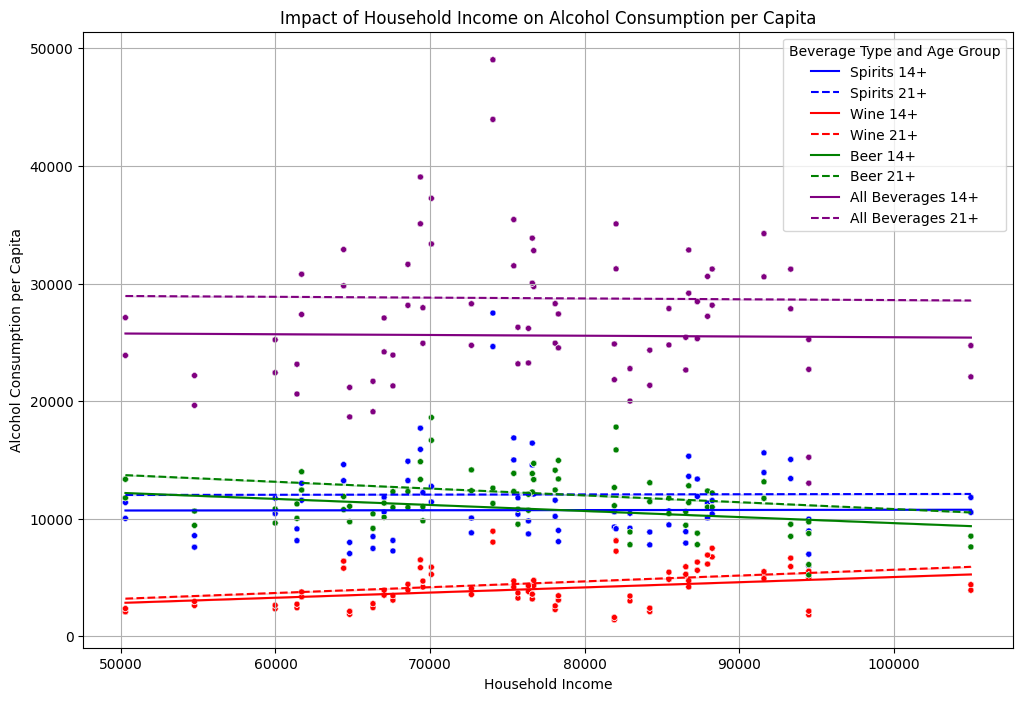

In [35]:
plt.figure(figsize=(12, 8))

for beverage, color in colors.items():
    for age_group, linestyle in line_styles.items():
        
        if age_group == '14+':
            y_values = 'Average(>14)'
        else:
            y_values = 'Average(>21)'

        subset = df[df['Beverage Type'] == beverage]
        X = subset[['Value_y']]
        y = subset[y_values]
        
        #calculatee the coefficient
        model = LinearRegression().fit(X, y)
        predicted = model.predict(X)
        
        # Save coefficients
        coefficients[(beverage, age_group)] = model.coef_[0]
        
        # Calculate residuals and identify outliers
        residuals = y - predicted
        Q1 = residuals.quantile(0.25)
        Q3 = residuals.quantile(0.75)
        lower_bound = Q1 - 1.5 * iqr(residuals)
        upper_bound = Q3 + 1.5 * iqr(residuals)
        
        outlier_indices = subset[(residuals < lower_bound) | (residuals > upper_bound)].index
        outliers_info[(beverage, age_group)] = {
            'outlier_indices': outlier_indices,
            'states': df.loc[outlier_indices, 'State'].unique().tolist(),  # Getting unique states
            'incomes': df.loc[outlier_indices, 'Value_y'].unique().tolist()  # Getting unique incomes
        }
        
        # Calculate Confidence Intervals
        n = len(X)
        stderr_res = np.std(residuals, ddof=1)
        stderr_X = np.std(X['Value_y'], ddof=1)
        t_val = stats.t.ppf(0.975, n - 2)
        stderr_b1 = stderr_res / (np.sqrt(np.sum((X['Value_y'] - X['Value_y'].mean()) ** 2)))
        conf_interval_b1 = (model.coef_[0] - t_val * stderr_b1, model.coef_[0] + t_val * stderr_b1)
        stderr_b0 = stderr_res * np.sqrt((1/n) + (X['Value_y'].mean()**2) / np.sum((X['Value_y'] - X['Value_y'].mean())**2))
        conf_interval_b0 = (model.intercept_ - t_val * stderr_b0, model.intercept_ + t_val * stderr_b0)

        # Calculate p-values
        sse = np.sum(residuals**2)
        sst = np.sum((y - y.mean())**2)
        rsq = 1 - (sse/sst)
        df_regression = 1
        df_residual = len(y) - 2
        f_statistic = (rsq/df_regression) / ((1 - rsq)/df_residual)
        p_value = 1 - stats.f.cdf(f_statistic, df_regression, df_residual)

        # Display values
        print(f"\n{beverage} - Age Group {age_group}")
        print(f"Coefficient: {model.coef_[0]:.4f}")
        print("Coefficient Confidence Interval (95%):", conf_interval_b1)
        print("Intercept Confidence Interval (95%):", conf_interval_b0)
        print(f"p-value for coefficient: {p_value:.4f}")
        
        #visualize the scatterpot
        sns.scatterplot(
            x=subset['Value_y'],
            y=subset[y_values],
            color=color,
            size=sizes[age_group],
            legend=False
        )
        #visualize the regresion line
        sns.lineplot(
            x=subset['Value_y'],
            y=predicted,
            color=color,
            linestyle=linestyle,
            label=f'{beverage} {age_group}'
        )

plt.legend(title='Beverage Type and Age Group')
plt.title('Impact of Household Income on Alcohol Consumption per Capita')
plt.xlabel('Household Income')
plt.ylabel('Alcohol Consumption per Capita')
plt.grid(True)
plt.show()

2.1.4 Display the result

In [36]:
# Display outliers information
print("\nOutliers Information:")
for (beverage, age_group), info in outliers_info.items():
    if info['states']:
        print(f"\nFor {beverage} and age group {age_group}:")
        for state, income in zip(info['states'], info['incomes']):
            y_val_column = 'Average(>14)' if age_group == '14+' else 'Average(>21)'
            y_value = df[(df['State'] == state) & (df['Beverage Type'] == beverage)][y_val_column].values[0]
            mean_value = means[(beverage, age_group, 'y')]

            print(f"State: {state}, Income: {income}")
            print(f"Alcohol Consumption: {y_value:.4f}, Mean Consumption for {beverage} {age_group}: {mean_value:.4f}")

            if y_value > mean_value:
                diff_percent = ((y_value - mean_value) / mean_value) * 100
                print(f"State's consumption is higher than the mean by {y_value - mean_value:.4f} ({diff_percent:.2f}%)")
            elif y_value < mean_value:
                diff_percent = ((mean_value - y_value) / mean_value) * 100
                print(f"State's consumption is lower than the mean by {mean_value - y_value:.4f} ({diff_percent:.2f}%)")
            else:
                print("State's consumption is exactly at the mean.")


Outliers Information:

For Spirits and age group 14+:
State: Delaware, Income: 74070
Alcohol Consumption: 24645.0000, Mean Consumption for Spirits 14+: 10736.1053
State's consumption is higher than the mean by 13908.8947 (129.55%)

For Spirits and age group 21+:
State: Delaware, Income: 74070
Alcohol Consumption: 27492.0000, Mean Consumption for Spirits 21+: 12066.0526
State's consumption is higher than the mean by 15425.9474 (127.85%)

For Wine and age group 14+:
State: Delaware, Income: 74070
Alcohol Consumption: 8013.0000, Mean Consumption for Wine 14+: 4018.1316
State's consumption is higher than the mean by 3994.8684 (99.42%)

For Wine and age group 21+:
State: Delaware, Income: 74070
Alcohol Consumption: 8939.0000, Mean Consumption for Wine 21+: 4510.5263
State's consumption is higher than the mean by 4428.4737 (98.18%)

For All Beverages and age group 14+:
State: Delaware, Income: 74070
Alcohol Consumption: 43958.0000, Mean Consumption for All Beverages 14+: 25588.2368
State's 

2.1.5 OUTPUT INTERPRETATION

2.2 Linear regression analysis for State average temperature and Alcohol consumption per capita

2.2.1 Prepare variables and dictionaries

In [15]:
#data wrangling

df= df[df['Climate Index'] == 'Average Temperature']
df['Value_x'] = df['Value_x'].str.replace('°F', '').astype(float)

#Define colors for alcohol types
colors = {
    'Spirits': 'blue',
    'Wine': 'red',
    'Beer': 'green',
    'All Beverages': 'purple'
}

# Define sizes and line styles for age groups
sizes = {
    '14+': 50,
    '21+': 100
}

line_styles = {
    '14+': '-',
    '21+': '--'
}

# Dictionary to store mean, coefficients, outlier information

means = {}
coefficients = {}
outliers_info = {}

2.2.2 Descriptive data analysis

In [16]:
for beverage, color in colors.items():
    for age_group, linestyle in line_styles.items():
        
        if age_group == '14+':
            y_values = 'Average(>14)'
        else:
            y_values = 'Average(>21)'

        subset = df[df['Beverage Type'] == beverage]

        # Calculate means of State average tempreture and alcohol consumption per capita
        means[(beverage, age_group, 'x')] = subset['Value_x'].mean()
        means[(beverage, age_group, 'y')] = subset[y_values].mean()

        # Print the calculated means
        print(f"\nFor {beverage} and age group {age_group} - X (Value_x):")
        print(f"Mean: {means[(beverage, age_group, 'x')]:.4f}")
        print(f"\nFor {beverage} and age group {age_group} - Y (Consumption):")
        print(f"Mean: {means[(beverage, age_group, 'y')]:.4f}")


For Spirits and age group 14+ - X (Value_x):
Mean: 54.3842

For Spirits and age group 14+ - Y (Consumption):
Mean: 10736.1053

For Spirits and age group 21+ - X (Value_x):
Mean: 54.3842

For Spirits and age group 21+ - Y (Consumption):
Mean: 12066.0526

For Wine and age group 14+ - X (Value_x):
Mean: 54.3842

For Wine and age group 14+ - Y (Consumption):
Mean: 4018.1316

For Wine and age group 21+ - X (Value_x):
Mean: 54.3842

For Wine and age group 21+ - Y (Consumption):
Mean: 4510.5263

For Beer and age group 14+ - X (Value_x):
Mean: 54.3842

For Beer and age group 14+ - Y (Consumption):
Mean: 10833.9211

For Beer and age group 21+ - X (Value_x):
Mean: 54.3842

For Beer and age group 21+ - Y (Consumption):
Mean: 12183.4474

For All Beverages and age group 14+ - X (Value_x):
Mean: 54.3842

For All Beverages and age group 14+ - Y (Consumption):
Mean: 25588.2368

For All Beverages and age group 21+ - X (Value_x):
Mean: 54.3842

For All Beverages and age group 21+ - Y (Consumption):
Mea

2.2.3 Calculate the coefficent, visualize data and capture the outliers


Spirits - Age Group 14+
Coefficient: -68.8424
Coefficient Confidence Interval (95%): (-216.54076411181617, 78.85586653799592)
Intercept Confidence Interval (95%): (6373.194280007227, 22586.90070225743)
p-value for coefficient: 0.3573

Spirits - Age Group 21+
Coefficient: -76.6052
Coefficient Confidence Interval (95%): (-239.99132947021403, 86.78084346926383)
Intercept Confidence Interval (95%): (7264.245966741531, 25200.090621931195)
p-value for coefficient: 0.3545

Wine - Age Group 14+
Coefficient: -43.0771
Coefficient Confidence Interval (95%): (-113.84912537633487, 27.694993905246875)
Intercept Confidence Interval (95%): (2476.312693069303, 10245.37488846097)
p-value for coefficient: 0.2313

Wine - Age Group 21+
Coefficient: -47.9959
Coefficient Confidence Interval (95%): (-126.3415524508963, 30.349681321067855)
Intercept Confidence Interval (95%): (2820.51948343565, 11420.97527648286)
p-value for coefficient: 0.2283

Beer - Age Group 14+
Coefficient: -56.8085
Coefficient Confidenc

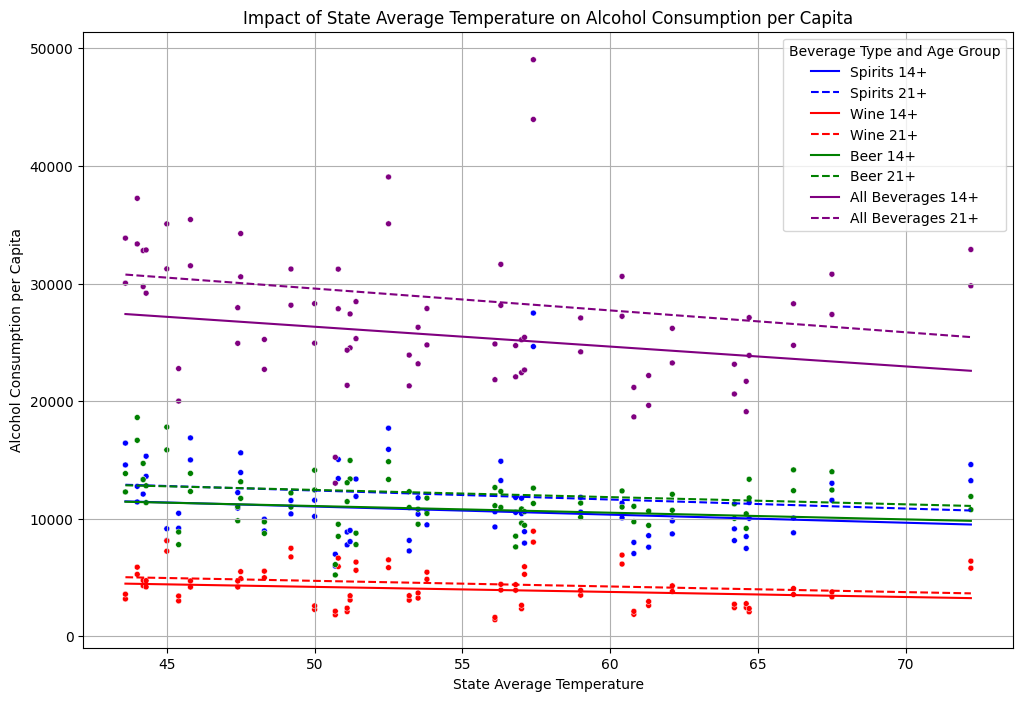

In [17]:

plt.figure(figsize=(12, 8))

for beverage, color in colors.items():
    for age_group, linestyle in line_styles.items():
        
        if age_group == '14+':
            y_values = 'Average(>14)'
        else:
            y_values = 'Average(>21)'

        subset = df[df['Beverage Type'] == beverage]
        X = subset[['Value_x']]
        y = subset[y_values]

        #calculate the coefficient
        model = LinearRegression().fit(X, y)
        predicted = model.predict(X)
        
        # Save coefficients
        coefficients[(beverage, age_group)] = model.coef_[0]
        
        # Calculate residuals and identify outliers
        residuals = y - predicted
        Q1 = residuals.quantile(0.25)
        Q3 = residuals.quantile(0.75)
        lower_bound = Q1 - 1.5 * iqr(residuals)
        upper_bound = Q3 + 1.5 * iqr(residuals)
        
        outlier_indices = subset[(residuals < lower_bound) | (residuals > upper_bound)].index
        outliers_info[(beverage, age_group)] = {
            'outlier_indices': outlier_indices,
            'states': df.loc[outlier_indices, 'State'].unique().tolist(),  # Getting unique states
            'temperatures': df.loc[outlier_indices, 'Value_x'].unique().tolist()  # Getting unique temperatures
        }

        # Calculate Confidence Intervals
        n = len(X)
        stderr_res = np.std(residuals, ddof=1)
        stderr_X = np.std(X['Value_x'], ddof=1)
        t_val = stats.t.ppf(0.975, n - 2)
        stderr_b1 = stderr_res / (np.sqrt(np.sum((X['Value_x'] - X['Value_x'].mean()) ** 2)))
        conf_interval_b1 = (model.coef_[0] - t_val * stderr_b1, model.coef_[0] + t_val * stderr_b1)
        stderr_b0 = stderr_res * np.sqrt((1/n) + (X['Value_x'].mean()**2) / np.sum((X['Value_x'] - X['Value_x'].mean())**2))
        conf_interval_b0 = (model.intercept_ - t_val * stderr_b0, model.intercept_ + t_val * stderr_b0)

        # Calculate p-values
        sse = np.sum(residuals**2)
        sst = np.sum((y - y.mean())**2)
        rsq = 1 - (sse/sst)
        df_regression = 1
        df_residual = len(y) - 2
        f_statistic = (rsq/df_regression) / ((1 - rsq)/df_residual)
        p_value = 1 - stats.f.cdf(f_statistic, df_regression, df_residual)

        # Display values
        print(f"\n{beverage} - Age Group {age_group}")
        print(f"Coefficient: {model.coef_[0]:.4f}")
        print("Coefficient Confidence Interval (95%):", conf_interval_b1)
        print("Intercept Confidence Interval (95%):", conf_interval_b0)
        print(f"p-value for coefficient: {p_value:.4f}")
        
        #visualize the scatterplot
        sns.scatterplot(
            x=subset['Value_x'],
            y=subset[y_values],
            color=color,
            size=sizes[age_group],
            legend=False
        )
        
        #visualize the regresion line
        sns.lineplot(
            x=subset['Value_x'],
            y=predicted,
            color=color,
            linestyle=linestyle,
            label=f'{beverage} {age_group}'
        )

plt.legend(title='Beverage Type and Age Group')
plt.title('Impact of State Average Temperature on Alcohol Consumption per Capita')
plt.xlabel('State Average Temperature')
plt.ylabel('Alcohol Consumption per Capita')
plt.grid(True)
plt.show()

2.2.4 Display the result

In [18]:
# Print outliers information
print("\nOutliers Information:")
for (beverage, age_group), info in outliers_info.items():
    if info['states']:
        print(f"\nFor {beverage} and age group {age_group}:")
        for state, temperature in zip(info['states'], info['temperatures']):
            y_val_column = 'Average(>14)' if age_group == '14+' else 'Average(>21)'
            y_value = df[(df['State'] == state) & (df['Beverage Type'] == beverage)][y_val_column].values[0]
            mean_value = means[(beverage, age_group, 'y')]

            print(f"State: {state}, Temperature: {temperature}")
            print(f"Alcohol Consumption: {y_value:.4f}, Mean Consumption for {beverage} {age_group}: {mean_value:.4f}")

            if y_value > mean_value:
                diff_percent = ((y_value - mean_value) / mean_value) * 100
                print(f"State's consumption is higher than the mean by {y_value - mean_value:.4f} ({diff_percent:.2f}%)")
            elif y_value < mean_value:
                diff_percent = ((mean_value - y_value) / mean_value) * 100
                print(f"State's consumption is lower than the mean by {mean_value - y_value:.4f} ({diff_percent:.2f}%)")
            else:
                print("State's consumption is exactly at the mean.")


Outliers Information:

For Spirits and age group 14+:
State: Delaware, Temperature: 57.4
Alcohol Consumption: 24645.0000, Mean Consumption for Spirits 14+: 10736.1053
State's consumption is higher than the mean by 13908.8947 (129.55%)

For Spirits and age group 21+:
State: Delaware, Temperature: 57.4
Alcohol Consumption: 27492.0000, Mean Consumption for Spirits 21+: 12066.0526
State's consumption is higher than the mean by 15425.9474 (127.85%)

For Wine and age group 14+:
State: Delaware, Temperature: 57.4
Alcohol Consumption: 8013.0000, Mean Consumption for Wine 14+: 4018.1316
State's consumption is higher than the mean by 3994.8684 (99.42%)

For Wine and age group 21+:
State: Delaware, Temperature: 57.4
Alcohol Consumption: 8939.0000, Mean Consumption for Wine 21+: 4510.5263
State's consumption is higher than the mean by 4428.4737 (98.18%)

For Beer and age group 14+:
State: Montana, Temperature: 44.0
Alcohol Consumption: 16671.0000, Mean Consumption for Beer 14+: 10833.9211
State's

2.2.5 OUTPUT INTERPRETATION

1. Coefficient analysis:
All types of alcohols show a negative relationship between state average temperature and alcohol consumption per capita, both in age group 14+ and 21+.The coefficient of -185.9417 for "All Beverages" and age group 21+ is the largest in absolute value among all the coefficients. This indicates a strong and significant negative relationship between household income and alcohol consumption for this specific category.
2. Outlier analysis:
(1) Delaware stands out as an outlier in various alcohol consumption categorie.
It has significantly higher alcohol consumption than the mean for spirits, wine, and all beverages, both for individuals aged 14+ and 21+
(2) Montana is notable for higher beer consumption among individuals aged 14+ and 21+.
Beer consumption in Montana is 53.88% and 52.75% higher than the mean for these respective age groups
(3) Utah stands out for lower beer consumption, both for individuals aged 14+ and 21+.
Beer consumption in Utah is 51.83% and 49.92% lower than the mean for these respective age groups
(4) Vermont: Vermont exhibits higher beer consumption among individuals aged 14+ and 21+.
Beer consumption in Vermont is 46.35% and 46.07% higher than the mean for these respective age groups...1+.
3. Hypothesis Test
Since all p-value is >0.05, there are not significant correlation between average temperature and alcohol consumption, but basically they have an insignifcant negtive correlation.

Section 3 PROJECT SUMMARY

THANK YOU FOR READING!